# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
from maddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch

In [8]:
SOLVED_SCORE = 0.5
CONSEC_EPISODES = 100
PRINT_EVERY = 10
ADD_NOISE = True

def maddpg(n_episodes=2000, max_t=1000, train_mode=True ):
    #MADDPG: Multi-Agent Deep Deterministic Policy Gradient
    #n_episodes  : maximum number of training episodes
    #max_t       : maximum number of timesteps per episode
    #train_mode  : set environment to training mode or not
    
    scores_window = deque(maxlen=CONSEC_EPISODES)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    already_solved = False
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode = train_mode)[brain_name]
        states = np.reshape(env_info.vector_observations, (1, 48))
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, ADD_NOISE)
            env_info = env.step(actions)[brain_name]
            next_states = np.reshape(env_info.vector_observations, (1,48))
            rewards = env_info.rewards
            done = env_info.local_done
            agent_0.step(states, actions, rewards[0], next_states, done, 0)
            agent_1.step(states, actions, rewards[1], next_states, done, 1)
            scores += np.max(rewards)
            states = next_states
            if np.any(done):
                break
                
        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))
        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
            
        if i_episode % PRINT_EVERY == 0:
            print("Episode {:0>4d}-{:0>4d}\t Max Reward: {:.3f}\t Moving Average: {:.3f}".format(i_episode - PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))

        if moving_average[-1] >= SOLVED_SCORE:
            if not already_solved:
                print('<-- Environment Solved in {:d} episodes. \n Moving Average: {:.3f} over past {:d} episodes'.format(i_episode-CONSEC_EPISODES, moving_average[-1], CONSEC_EPISODES))
                already_solved = True
                torch.save(agent_0.actor_local.state_dict(),  "models/checkpoint_actor_0.pth")
                torch.save(agent_0.critic_local.state_dict(), "models/checkpoint_critic_0.pth")
                torch.save(agent_1.actor_local.state_dict(),  "models/checkpoint_actor_1.pth")
                torch.save(agent_1.critic_local.state_dict(), "models/checkpoint_critic_1.pth")
            elif ep_best_score >= best_score:
                print("Best episode so far\n Episode {:0>4d}\t Max reward: {:.3f} \t Moving average: {:.3f}".format(i_episode, ep_best_score, moving_average[-1]))
                torch.save(agent_0.actor_local.state_dict(),  "models/checkpoint_actor_0.pth")
                torch.save(agent_0.critic_local.state_dict(), "models/checkpoint_critic_0.pth")
                torch.save(agent_1.actor_local.state_dict(),  "models/checkpoint_actor_1.pth")
                torch.save(agent_1.critic_local.state_dict(), "models/checkpoint_critic_1.pth")
            elif (i_episode - best_episode) >= 200:
                print("Training stopped. Best score not matched or exceeded for 200 episodes")
                break
            else:
                continue
                
    return scores_all, moving_average

def get_actions(states, add_noise):
    action_0 = agent_0.act(states, add_noise)
    action_1 = agent_1.act(states, add_noise)
    return np.concatenate((action_0, action_1), axis=0).flatten()

agent_0 = Agent(state_size, action_size, num_agents = 1, random_seed = 0)
agent_1 = Agent(state_size, action_size, num_agents = 1, random_seed = 0)

scores, avgs = maddpg()
            
    

Episode 0000-0010	 Max Reward: 0.000	 Moving Average: 0.000
Episode 0010-0020	 Max Reward: 0.000	 Moving Average: 0.000
Episode 0020-0030	 Max Reward: 0.100	 Moving Average: 0.013
Episode 0030-0040	 Max Reward: 0.100	 Moving Average: 0.013
Episode 0040-0050	 Max Reward: 0.000	 Moving Average: 0.010
Episode 0050-0060	 Max Reward: 0.100	 Moving Average: 0.012
Episode 0060-0070	 Max Reward: 0.100	 Moving Average: 0.013
Episode 0070-0080	 Max Reward: 0.200	 Moving Average: 0.014
Episode 0080-0090	 Max Reward: 0.400	 Moving Average: 0.017
Episode 0090-0100	 Max Reward: 0.100	 Moving Average: 0.017
Episode 0100-0110	 Max Reward: 0.100	 Moving Average: 0.019
Episode 0110-0120	 Max Reward: 0.000	 Moving Average: 0.019
Episode 0120-0130	 Max Reward: 0.100	 Moving Average: 0.017
Episode 0130-0140	 Max Reward: 0.200	 Moving Average: 0.019
Episode 0140-0150	 Max Reward: 0.100	 Moving Average: 0.021
Episode 0150-0160	 Max Reward: 0.100	 Moving Average: 0.022
Episode 0160-0170	 Max Reward: 0.100	 Mo

In [9]:
#torch.save(agent_0.actor_local.state_dict(),  "models/checkpoint_actor_0.pth")
#torch.save(agent_0.critic_local.state_dict(), "models/checkpoint_critic_0.pth")
#torch.save(agent_1.actor_local.state_dict(),  "models/checkpoint_actor_1.pth")
#torch.save(agent_1.critic_local.state_dict(), "models/checkpoint_critic_1.pth")

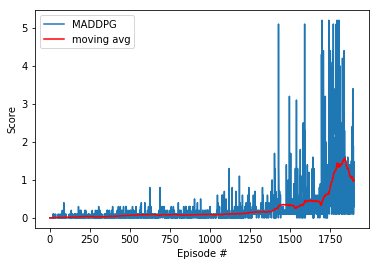

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label="MADDPG")
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()